In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pandas as pd

sys.path.append('..')

In [7]:
%load_ext autoreload
%autoreload 2

# Teacher Models

## Beta-Binomial

In [56]:
from src.DataGenerator import DataGenerator

# init
gen = DataGenerator()

# set data params
dataset = 1
n_samples = 100

# generate data set 1
X, y, price, optimal_price = gen.generate_data(dataset, n_samples, seed=121)
X.head()

,X0,X1
0,4.787967,4.715071
1,4.669889,6.183695
2,4.985881,5.629642
3,5.401873,4.808573
4,4.209585,4.267278


In [ ]:
from src.teachers.BinomGLM import BinomGLM

# init binomial generalize linear model
mod = BinomGLM()

# fit
mod.fit(price, X, y, draws=100)

# print summary
sum = mod.summary()
print(sum.head())

# Posterior analysis
mod.plot_trace()
plt.show()

In [ ]:
mod.alpha.shape

### Get Posteriors 

For each user with covariates x, get a purchase probability posteriors for a price.

- We can see heterogneity in the demand curves for customers at a given price. some are more willing to buy than others.

In [ ]:
# get predictions
r = mod.predict_proba(price=5, X=X)

# save model as JSON
mod.save_params(f'../data/model=binomglm&dataset={dataset}&n_samples={n_samples}')

# all data points get a posterior 
# probability of purchase
print(r.shape)

# plot ten customers posteriors
sns.kdeplot(r[:10, :].T)

plt.title('10 Purchasing Decisions')
plt.xlabel('Probability of purchase')
plt.show()

### Visualize Demand Curve

 - Overall demand on average decreases.

In [ ]:
# get prices
prices = np.linspace(
    price.quantile(0.05), 
    price.quantile(0.95), 
    9
)

# get average purchase probability
avg_probas = [
    (mod.predict_proba(price, X=X).mean(axis=1) * price).sum()
    for price in prices
]

plt.plot(prices, avg_probas)

plt.title('Customer Revenue Curve')
plt.ylabel('Avg. Customer Purchase Revenue')
plt.xlabel('Price')

plt.show()

## Bayesian Additive Regression Trees

Only 10 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
PGBART: [logits]


Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 30 seconds.
The number of samples is too small to check convergence reliably.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
logits[0]  0.58  0.60   -0.15     1.82       0.24     0.18      6.36   
logits[1] -4.41  0.42   -5.19    -3.78       0.14     0.10      8.86   
logits[2] -3.49  0.94   -4.50    -1.85       0.38     0.29      6.32   
logits[3] -1.34  0.63   -2.24    -0.55       0.23     0.18      8.23   
logits[4] -1.70  0.55   -2.53    -0.51       0.14     0.11     19.34   

           ess_tail  r_hat  
logits[0]     21.74   1.88  
logits[1]     26.02   1.34  
logits[2]     21.74   1.84  
logits[3]     21.74   1.49  
logits[4]     21.74   1.20  


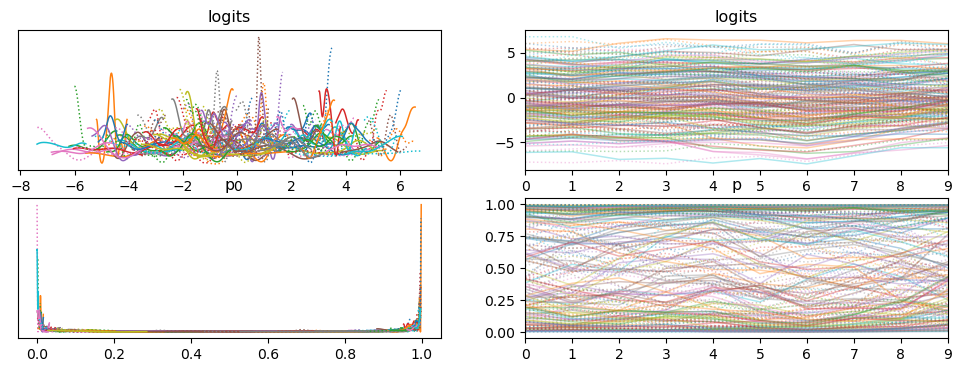

In [44]:
from src.teachers.BayesianTree import BayesianTree

# init binomial generalize linear model
bart = BayesianTree()

# fit
bart.fit(price, X, y, draws=10)

# print summary
sum = bart.summary()
print(sum.head())

# Posterior analysis
bart.plot_trace()
plt.show()

In [51]:
prices

NameError: name 'prices' is not defined

In [57]:
price

0     4.426102
1     6.615373
2     6.709641
3     6.403826
4     5.087744
        ...   
95    5.268599
96    4.746663
97    4.309623
98    4.360341
99    3.459920
Name: price, Length: 100, dtype: float64

Sampling: [logits]


Sampling: [logits]


(100, 20)


Sampling: [logits]


(100, 20)


(100, 20)


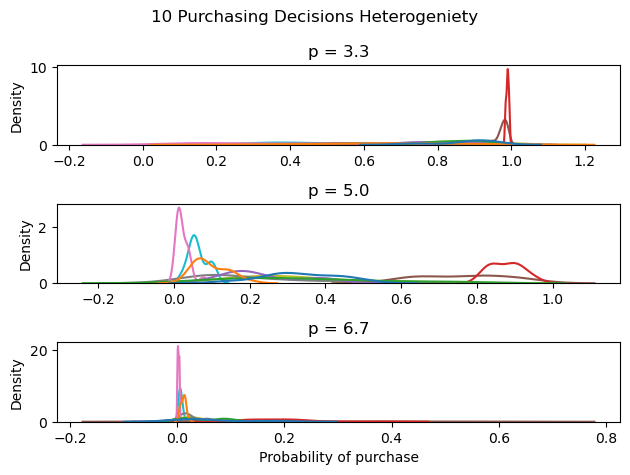

In [65]:
# save model as JSON
# bart.save_params(f'../data/model=bart&dataset={dataset}&n_samples={n_samples}')

# all data points get a posterior 
# probability of purchase

# get prices
prices = np.linspace(
    price.quantile(0.05),
    price.quantile(0.95),
    3
)

fig, ax = plt.subplots(3, 1)
# plot ten customers posteriors
for i, p in enumerate(prices):
    r = bart.predict_proba(p, X)
    print(r.shape)
    sns.kdeplot(r[:10, :].T, ax=ax[i])

    ax[i].get_legend().set_visible(False) 
    ax[i].set_title(f'p = {round(p, 1)}')

plt.suptitle('10 Purchasing Decisions Heterogeniety')
plt.xlabel('Probability of purchase')
plt.tight_layout()

plt.show()